In [ ]:
#Scene Text Recognition using CNN-LSTM-CTC

In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.layers.core import Layer

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

from collections import Counter

from PIL import Image

In [ ]:
# tf.__version__

'2.15.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/mjsynth_sample.zip

In [ ]:
final_paths = []
final_texts = []

data_folder = "/content/mjsynth_sample"
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split("_")[1])

In [ ]:
vocab = set("".join(map(str, final_texts)))
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [ ]:
encode_to_labels("HELLO")

[17, 14, 21, 21, 24]

In [ ]:
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]

In [ ]:
len(train_final_paths), len(val_final_paths)

(47410, 5268)

In [ ]:
max_label_len = max([len(str(text)) for text in final_texts])
max_label_len

23

In [ ]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):

            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:

                pass

        return [np.array(images),
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)),
               np.array(train_input_length),
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
train_final_paths[:1], train_final_texts[:1]

(['/content/mjsynth_sample/114_ithacan_41037.jpg'], ['ithacan'])

In [ ]:
!nvidia-smi

Wed May  1 20:55:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
batch_size = 256
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func,
                  output_shape=(1,),
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
file_path = "finalModel.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')


checkpoint = ModelCheckpoint(filepath=file_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
epochs = 40

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/40
185/185 [==============================] - ETA: 0s - loss: 31.4752
Epoch 1: val_loss improved from inf to 35.41569, saving model to finalModel.hdf5
185/185 [==============================] - 68s 295ms/step - loss: 31.4752 - val_loss: 35.4157


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
185/185 [==============================] - ETA: 0s - loss: 28.3478
Epoch 2: val_loss improved from 35.41569 to 28.91970, saving model to finalModel.hdf5
185/185 [==============================] - 53s 287ms/step - loss: 28.3478 - val_loss: 28.9197
Epoch 3/40
185/185 [==============================] - ETA: 0s - loss: 26.4379
Epoch 3: val_loss improved from 28.91970 to 26.12722, saving model to finalModel.hdf5
185/185 [==============================] - 49s 266ms/step - loss: 26.4379 - val_loss: 26.1272
Epoch 4/40
185/185 [==============================] - ETA: 0s - loss: 23.7319
Epoch 4: val_loss improved from 26.12722 to 23.30919, saving model to finalModel.hdf5
185/185 [==============================] - 52s 282ms/step - loss: 23.7319 - val_loss: 23.3092
Epoch 5/40
185/185 [==============================] - ETA: 0s - loss: 17.6864
Epoch 5: val_loss improved from 23.30919 to 14.55379, saving model to finalModel.hdf5
185/185 [==============================] - 48s 257ms/step - lo

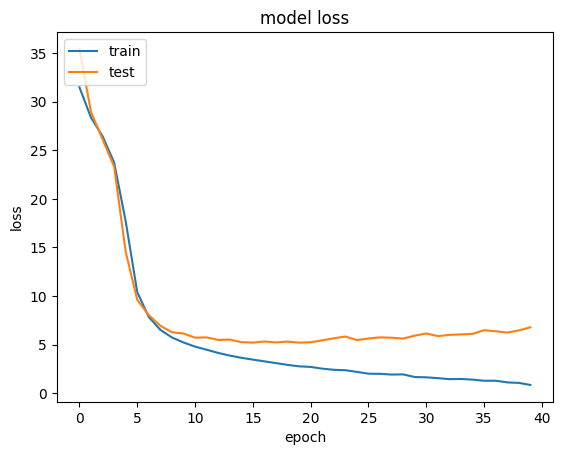

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def pre_process_image(path):

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))


    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.

    return img

In [ ]:
act_model.load_weights('C_LSTM_best.hdf5')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')

        print('\n')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text
    result = ""
    for x in out:

        print("predicted text = ", end = '')
        predicted_word = ""
        for p in x:

            if int(p) != -1:
                ch = char_list[int(p)]
                print(ch, end = '')
                predicted_word += ch
        print('\n')
        result += predicted_word
    return result



1/1 [==============================] - 0s 20ms/step
predicted text = Roar

Prediction: Roar, CER: 0.0




1/1 [==============================] - 0s 19ms/step
predicted text = PROSCENIUMS

Prediction: PROSCENIUMS, CER: 0.0




1/1 [==============================] - 0s 22ms/step
predicted text = BONToNNIeRs

Prediction: BONToNNIeRs, CER: 0.36363636363636365




1/1 [==============================] - 0s 20ms/step
predicted text = Janice

Prediction: Janice, CER: 0.0




1/1 [==============================] - 0s 19ms/step
predicted text = PEDICURE

Prediction: PEDICURE, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Roaghshod

Prediction: Roaghshod, CER: 0.1111111111111111




1/1 [==============================] - 0s 19ms/step
predicted text = CREOTWORTHY

Prediction: CREOTWORTHY, CER: 0.16666666666666666


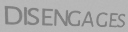



1/1 [==============================] - 0s 19ms/step
predicted text = DISENGACES

Prediction: DISENGACES, CER: 1.0




1/1 [==============================] - 0s 18ms/step
predicted text = INVALIBLY

Prediction: INVALIBLY, CER: 0.1111111111111111




1/1 [==============================] - 0s 19ms/step
predicted text = Array

Prediction: Array, CER: 0.0




1/1 [==============================] - 0s 21ms/step
predicted text = zer

Prediction: zer, CER: 0.3333333333333333




1/1 [==============================] - 0s 19ms/step
predicted text = osculated

Prediction: osculated, CER: 0.0




1/1 [==============================] - 0s 19ms/step
predicted text = Airnatls

Prediction: Airnatls, CER: 0.25




1/1 [==============================] - 0s 20ms/step
predicted text = rebellions

Prediction: rebellions, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Piatting

Prediction: Piatting, CER: 0.125




1/1 [==============================] - 0s 18ms/step
predicted text = GODCHILD

Prediction: GODCHILD, CER: 0.0




1/1 [==============================] - 0s 20ms/step
predicted text = Beekeeping

Prediction: Beekeeping, CER: 0.0




1/1 [==============================] - 0s 24ms/step
predicted text = MENDICAINCY

Prediction: MENDICAINCY, CER: 0.09090909090909091


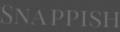



1/1 [==============================] - 0s 18ms/step
predicted text = SnappIsi

Prediction: SnappIsi, CER: 0.25




1/1 [==============================] - 0s 18ms/step
predicted text = Dignity

Prediction: Dignity, CER: 0.0




1/1 [==============================] - 0s 21ms/step
predicted text = CROTTABIIITY

Prediction: CROTTABIIITY, CER: 0.4166666666666667




1/1 [==============================] - 0s 18ms/step
predicted text = PIONEER

Prediction: PIONEER, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = TEAI

Prediction: TEAI, CER: 0.25




1/1 [==============================] - 0s 17ms/step
predicted text = Unfitered

Prediction: Unfitered, CER: 0.1




1/1 [==============================] - 0s 17ms/step
predicted text = Chainsawed

Prediction: Chainsawed, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = ALFREDO

Prediction: ALFREDO, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Romonandins

Prediction: Romonandins, CER: 0.6363636363636364




1/1 [==============================] - 0s 20ms/step
predicted text = Pistachio

Prediction: Pistachio, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = privatizations

Prediction: privatizations, CER: 0.0




1/1 [==============================] - 0s 24ms/step
predicted text = Jereniah

Prediction: Jereniah, CER: 0.125




1/1 [==============================] - 0s 18ms/step
predicted text = PRETERNATURAL

Prediction: PRETERNATURAL, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Commissioner

Prediction: Commissioner, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Naphthalene

Prediction: Naphthalene, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = TOUCHENER

Prediction: TOUCHENER, CER: 0.1111111111111111




1/1 [==============================] - 0s 18ms/step
predicted text = Rehi

Prediction: Rehi, CER: 0.0




1/1 [==============================] - 0s 27ms/step
predicted text = tessellated

Prediction: tessellated, CER: 0.0




1/1 [==============================] - 0s 67ms/step
predicted text = liefer

Prediction: liefer, CER: 0.0




1/1 [==============================] - 0s 29ms/step
predicted text = ELBVATOR

Prediction: ELBVATOR, CER: 0.125




1/1 [==============================] - 0s 29ms/step
predicted text = Deluding

Prediction: Deluding, CER: 0.0




1/1 [==============================] - 0s 70ms/step
predicted text = Godforsaken

Prediction: Godforsaken, CER: 0.0




1/1 [==============================] - 0s 86ms/step
predicted text = Yttrium

Prediction: Yttrium, CER: 0.0


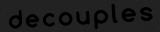



1/1 [==============================] - 0s 87ms/step
predicted text = decouples

Prediction: decouples, CER: 0.0




1/1 [==============================] - 0s 56ms/step
predicted text = Laurdlos

Prediction: Laurdlos, CER: 0.75




1/1 [==============================] - 0s 38ms/step
predicted text = unsuitably

Prediction: unsuitably, CER: 0.0




1/1 [==============================] - 0s 29ms/step
predicted text = Abdications

Prediction: Abdications, CER: 0.0




1/1 [==============================] - 0s 37ms/step
predicted text = Slatahearhus

Prediction: Slatahearhus, CER: 0.5384615384615384




1/1 [==============================] - 0s 28ms/step
predicted text = RECUPERATING

Prediction: RECUPERATING, CER: 0.0




1/1 [==============================] - 0s 37ms/step
predicted text = LASTING

Prediction: LASTING, CER: 0.0




1/1 [==============================] - 0s 53ms/step
predicted text = BLIP

Prediction: BLIP, CER: 0.0




1/1 [==============================] - 0s 33ms/step
predicted text = GARIACK

Prediction: GARIACK, CER: 0.2857142857142857




1/1 [==============================] - 0s 29ms/step
predicted text = absolute

Prediction: absolute, CER: 0.0




1/1 [==============================] - 0s 29ms/step
predicted text = LOVEY

Prediction: LOVEY, CER: 0.0




1/1 [==============================] - 0s 52ms/step
predicted text = punier

Prediction: punier, CER: 0.0




1/1 [==============================] - 0s 62ms/step
predicted text = stainless

Prediction: stainless, CER: 0.0




1/1 [==============================] - 0s 70ms/step
predicted text = TREASON

Prediction: TREASON, CER: 0.0




1/1 [==============================] - 0s 74ms/step
predicted text = leaktier

Prediction: leaktier, CER: 0.25




1/1 [==============================] - 0s 19ms/step
predicted text = teed

Prediction: teed, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = BURROWED

Prediction: BURROWED, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Nieces

Prediction: Nieces, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = ASPRANTS

Prediction: ASPRANTS, CER: 0.1111111111111111




1/1 [==============================] - 0s 20ms/step
predicted text = Tangelor

Prediction: Tangelor, CER: 0.125




1/1 [==============================] - 0s 18ms/step
predicted text = mainstreams

Prediction: mainstreams, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = liqueurs

Prediction: liqueurs, CER: 0.125




1/1 [==============================] - 0s 19ms/step
predicted text = Canoeists

Prediction: Canoeists, CER: 0.0




1/1 [==============================] - 0s 19ms/step
predicted text = DESALINATING

Prediction: DESALINATING, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Unpeis

Prediction: Unpeis, CER: 0.5714285714285714




1/1 [==============================] - 0s 19ms/step
predicted text = somalians

Prediction: somalians, CER: 0.0




1/1 [==============================] - 0s 21ms/step
predicted text = DENTURE

Prediction: DENTURE, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = DtteY

Prediction: DtteY, CER: 1.0




1/1 [==============================] - 0s 18ms/step
predicted text = Morphs

Prediction: Morphs, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = comph

Prediction: comph, CER: 0.2




1/1 [==============================] - 0s 18ms/step
predicted text = Kopeck

Prediction: Kopeck, CER: 0.0




1/1 [==============================] - 0s 18ms/step
predicted text = Exten

Prediction: Exten, CER: 0.4




1/1 [==============================] - 0s 27ms/step
predicted text = heypunching

Prediction: heypunching, CER: 0.09090909090909091




1/1 [==============================] - 0s 30ms/step
predicted text = Meditates

Prediction: Meditates, CER: 0.0




1/1 [==============================] - 0s 34ms/step
predicted text = coarsen

Prediction: coarsen, CER: 0.0




1/1 [==============================] - 0s 45ms/step
predicted text = Badistically

Prediction: Badistically, CER: 0.08333333333333333




1/1 [==============================] - 0s 38ms/step
predicted text = shaw

Prediction: shaw, CER: 0.0




1/1 [==============================] - 0s 31ms/step
predicted text = FARMYARD

Prediction: FARMYARD, CER: 0.0




1/1 [==============================] - 0s 34ms/step
predicted text = DAVITA

Prediction: DAVITA, CER: 0.0




1/1 [==============================] - 0s 36ms/step
predicted text = SPOKESMAN

Prediction: SPOKESMAN, CER: 0.0




1/1 [==============================] - 0s 26ms/step
predicted text = BRSIED

Prediction: BRSIED, CER: 0.5714285714285714




1/1 [==============================] - 0s 29ms/step
predicted text = hypoglycenics

Prediction: hypoglycenics, CER: 0.07692307692307693




1/1 [==============================] - 0s 33ms/step
predicted text = Tubercles

Prediction: Tubercles, CER: 0.0




1/1 [==============================] - 0s 36ms/step
predicted text = SHRIED

Prediction: SHRIED, CER: 0.14285714285714285




1/1 [==============================] - 0s 31ms/step
predicted text = BLOODYING

Prediction: BLOODYING, CER: 0.0




1/1 [==============================] - 0s 25ms/step
predicted text = intemperencs

Prediction: intemperencs, CER: 0.16666666666666666




1/1 [==============================] - 0s 35ms/step
predicted text = loleetd

Prediction: loleetd, CER: 0.7777777777777778




1/1 [==============================] - 0s 37ms/step
predicted text = shriveled

Prediction: shriveled, CER: 0.0




1/1 [==============================] - 0s 26ms/step
predicted text = Tonsed

Prediction: Tonsed, CER: 0.16666666666666666




1/1 [==============================] - 0s 35ms/step
predicted text = Setined

Prediction: Setined, CER: 0.5555555555555556




1/1 [==============================] - 0s 27ms/step
predicted text = VACILLATING

Prediction: VACILLATING, CER: 0.0




1/1 [==============================] - 0s 30ms/step
predicted text = Wigglers

Prediction: Wigglers, CER: 0.0




1/1 [==============================] - 0s 36ms/step
predicted text = toindsock

Prediction: toindsock, CER: 0.2222222222222222




1/1 [==============================] - 0s 37ms/step
predicted text = CYCLADES

Prediction: CYCLADES, CER: 0.0




1/1 [==============================] - 0s 38ms/step
predicted text = idolatresses

Prediction: idolatresses, CER: 0.08333333333333333




1/1 [==============================] - 0s 39ms/step
predicted text = paez

Prediction: paez, CER: 0.0


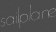



1/1 [==============================] - 0s 41ms/step
predicted text = ralplons

Prediction: ralplons, CER: 0.4444444444444444




1/1 [==============================] - 0s 27ms/step
predicted text = Changeover

Prediction: Changeover, CER: 0.0




1/1 [==============================] - 0s 27ms/step
predicted text = pretenses

Prediction: pretenses, CER: 0.0
Average CER: 0.12304742479742481


In [ ]:
from IPython.display import display
from random import randrange
import editdistance

accum_cer = []
for i in range(100):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predicted_text = predict_output(test_img)
    ground_truth_text = val_final_texts[index]

    distance = editdistance.eval(predicted_text, ground_truth_text)

    # Compute Character Error Rate
    cer = distance / max(len(predicted_text), len(ground_truth_text))
    print(f"Prediction: {predicted_text}, CER: {cer}")
    accum_cer.append(cer)

In [ ]:
print(f"Average CER: {np.average(accum_cer)}")

Average CER: 0.12304742479742481
